# This notebook outlines the data processing approach for the JOC article
    
To access the data and run the notebooks, you must perform the following steps:

1) Navigate to http://tiny.cc/JOC-XX-XXXX, where the XX-XXXX is the manuscript number on manuscript central.

2) Download the file, named data.tar.gz.  It has the following checksum information

![title](checksum.jpg)

3) ungz and untar the folder 'data' into the mcs_future folder. These files represent post-processed data and not the entire dataset.  This is due to the very large size of the three datasets, the raw derived data, and the amount of time it takes to run the training and classification.  However, applying the methods of this paper to the publically available data will give you the same results. If you downloaded the entire github project, the directories for the data folder and its subfolders should be:

/MCS/mcs_future/data/raw_data

/MCS/mcs_future/data/shapefiles

/MCS/mcs_future/data/slice_data

/MCS/mcs_future/data/wrf_data

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import sys
sys.path.append('C:/users/ahaberlie/documents/github/MCS/')

data_dir = "../data/slice_data/"

data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
        'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

for subset in ['mcs', 'qlcs', 'non_qlcs']:
    
    filename = data_dir + "master_{}_pgw_project.csv".format(subset)
    
    df = pd.read_csv(filename)
    df['datetime'] = pd.to_datetime(df.datetime)
    df = df.set_index('datetime')
    
    for dataset in ['OBS', 'CTRL', 'PGW']:

        data[subset][dataset] = df[df.run.values==dataset].copy()

# Draw all June - August OBS tracks

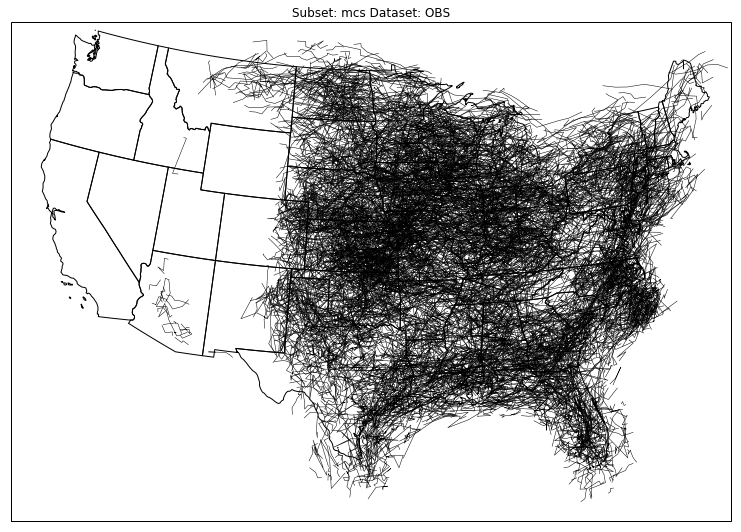

In [2]:
import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import generate_view, NOWrad_to_lon_lat, wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(plt, -120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'OBS'
df_ = data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Draw all June - August CTRL Tracks

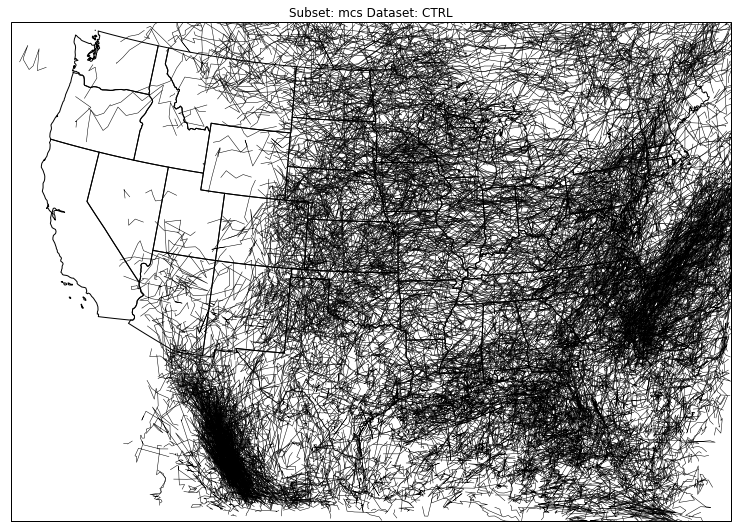

In [3]:
import cartopy
import cartopy.crs as ccrs
from mcs_future.utils.mapping_help import generate_view, NOWrad_to_lon_lat, wrf_to_lon_lat
import matplotlib.pyplot as plt
from netCDF4 import Dataset
%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 10

from_proj = ccrs.PlateCarree()
to_proj = ccrs.AlbersEqualArea(central_longitude=-95, central_latitude=38.0000)

view = generate_view(plt, -120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'CTRL'
df_ = data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

nc = Dataset("../data/wrf_data/RALconus4km_wrf_constants.nc")
lons = nc.variables['XLONG'][:,:]
lats = nc.variables['XLAT'][:,:]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Subset: " + subset + " Dataset: " + dataset)

# Get only those tracks that intersect the Midwest

In [4]:
import sys
import geopandas as gpd
from mcs_future.utils.mapping_help import get_point_subset

mw_shp_dir = "../data/shapefiles/map/"
wrf_dir = "../data/wrf_data/"
wrf_data_file = "RALconus4km_wrf_constants.nc"

mw_data = {'mcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'qlcs':{'OBS':None, 'CTRL':None, 'PGW':None},
           'non_qlcs':{'OBS':None, 'CTRL':None, 'PGW':None}}

outline = gpd.read_file(mw_shp_dir + "midwest_outline_latlon_grids.shp")

for sub_key, sub_value in data.items():
    
    for dset_key, dset_val in sub_value.items():
        
        if dset_key == 'OBS':
            mw_data[sub_key][dset_key] = get_point_subset(dset_val.copy(), outline)
        else:
            mw_data[sub_key][dset_key] = get_point_subset(dset_val.copy(), 
                                                          outline, wrf_dir + wrf_data_file)

# Draw OBS tracks that intersect Midwest

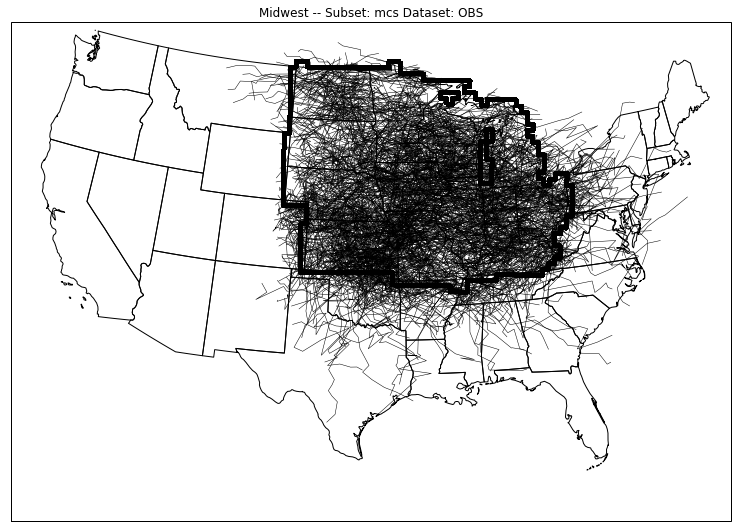

In [5]:
from mcs_future.utils.mapping_help import draw_midwest

view = generate_view(plt, -120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'OBS'
df_ = mw_data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    
    draw_midwest(view)

# Draw CTRL tracks that intersect Midwest

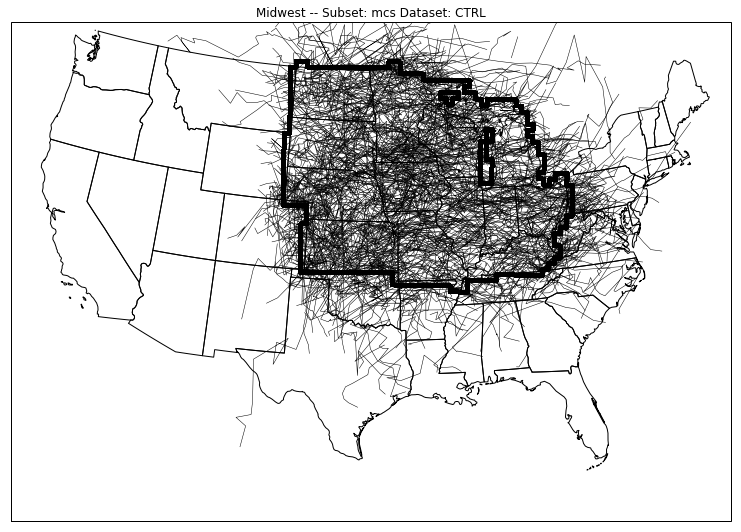

In [6]:
view = generate_view(plt, -120, -73, 20, 50, from_proj, to_proj)

subset = 'mcs'
dataset = 'CTRL'
df_ = mw_data[subset][dataset]
df_ = df_[df_.index.month.isin([6,7,8])]

for sid, swath in df_.groupby('storm_num'):

    xp = np.array([np.mean([x1, x2]) for (x1, x2) in zip(swath.xmin.values, swath.xmax.values)])
    yp = np.array([np.mean([y1, y2]) for (y1, y2) in zip(swath.ymin.values, swath.ymax.values)])

    if dataset == 'OBS':
        xp, yp = NOWrad_to_lon_lat(xp, yp)
    else:
        xp, yp = wrf_to_lon_lat(lons, lats, xp.astype(int), yp.astype(int))

    view.plot(xp, yp, 'k-', lw=0.5, transform=from_proj)
    view.set_title("Midwest -- Subset: " + subset + " Dataset: " + dataset)
    draw_midwest(view)

# Get counts of events from Midwest

In [7]:
import numpy as np

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    
    for dset_key in ['OBS', 'CTRL', 'PGW']:
        
        dset_val = mw_data[sub_key][dset_key].copy()
        total_count = dset_val.storm_num.nunique()
        
        seasons = {'djf':(12, 1, 2), 'mam':(3, 4, 5), 'jja':(6, 7, 8), 'son':(9, 10, 11)}
        
        for season_id, season_vals in seasons.items():
            
            dset_ = dset_val[dset_val.index.month.isin(season_vals)].copy()
            perc = "{0:.2f}".format(100*(dset_.storm_num.nunique() / total_count)) 
            seasons[season_id] = perc
        
        print(sub_key, dset_key, "Total Count:", total_count, 
              ", % DJF", seasons['djf'], ', % MAM', seasons['mam'], 
              ', % JJA', seasons['jja'], ', % SON', seasons['son'], '\n')    


mcs OBS Total Count: 3469 , % DJF 2.57 , % MAM 26.92 , % JJA 56.04 , % SON 14.82 

mcs CTRL Total Count: 2735 , % DJF 2.71 , % MAM 35.58 , % JJA 49.80 , % SON 12.32 

mcs PGW Total Count: 3057 , % DJF 4.81 , % MAM 38.70 , % JJA 40.37 , % SON 16.58 

qlcs OBS Total Count: 1777 , % DJF 2.87 , % MAM 27.29 , % JJA 56.11 , % SON 14.07 

qlcs CTRL Total Count: 792 , % DJF 3.28 , % MAM 41.79 , % JJA 44.70 , % SON 10.86 

qlcs PGW Total Count: 934 , % DJF 5.35 , % MAM 44.97 , % JJA 35.87 , % SON 14.35 

non_qlcs OBS Total Count: 1692 , % DJF 2.25 , % MAM 26.54 , % JJA 55.97 , % SON 15.60 

non_qlcs CTRL Total Count: 1943 , % DJF 2.47 , % MAM 33.04 , % JJA 51.88 , % SON 12.92 

non_qlcs PGW Total Count: 2123 , % DJF 4.57 , % MAM 35.94 , % JJA 42.35 , % SON 17.57 



# Show monthly percentages of events

In [8]:
from calendar import month_name as mname

col_names = ['key'] + [str(x) for x in range(1, 13)]

months = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        total_count = dset_val.storm_num.nunique()

        for month in list(range(1, 13)):
            
            dset_ = dset_val[dset_val.index.month==month].copy()
            
            months[str(month)].append(100*(dset_.storm_num.nunique() / total_count))
            
        months['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(months)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = mname[int(group.idxmax(axis=1).values[0])]
    min_idx = mname[int(group.idxmin(axis=1).values[0])]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax Month:", max_idx, "\nMax Percentage:", "{:0.2f}".format(max_val), "%",
               "\nMin Month:", min_idx, "\nMin Percentage:", "{:0.2f}".format(min_val), "%", 
               "\nMax Percentage Diff", "{:0.2f}".format(max_val - min_val), "%\n")
    
df[col_names[1:]]

mcs_CTRL 
Max Month: June 
Max Percentage: 22.30 % 
Min Month: December 
Min Percentage: 0.77 % 
Max Percentage Diff 21.54 %

mcs_OBS 
Max Month: July 
Max Percentage: 19.83 % 
Min Month: December 
Min Percentage: 0.69 % 
Max Percentage Diff 19.14 %

mcs_PGW 
Max Month: June 
Max Percentage: 19.82 % 
Min Month: January 
Min Percentage: 1.24 % 
Max Percentage Diff 18.58 %

non_qlcs_CTRL 
Max Month: June 
Max Percentage: 20.02 % 
Min Month: January 
Min Percentage: 0.62 % 
Max Percentage Diff 19.40 %

non_qlcs_OBS 
Max Month: July 
Max Percentage: 21.04 % 
Min Month: January 
Min Percentage: 0.53 % 
Max Percentage Diff 20.51 %

non_qlcs_PGW 
Max Month: June 
Max Percentage: 18.18 % 
Min Month: January 
Min Percentage: 1.08 % 
Max Percentage Diff 17.10 %

qlcs_CTRL 
Max Month: June 
Max Percentage: 27.90 % 
Min Month: December 
Min Percentage: 0.76 % 
Max Percentage Diff 27.15 %

qlcs_OBS 
Max Month: June 
Max Percentage: 19.86 % 
Min Month: December 
Min Percentage: 0.68 % 
Max Percentag

,1,2,3,4,5,6,7,8,9,10,11,12
key,,,,,,,,,,,,
mcs_OBS,0.864803,1.008936,4.035745,8.532718,14.557509,18.477948,19.832805,17.959066,9.022773,4.179879,1.729605,0.691842
mcs_CTRL,0.804388,1.133455,5.557587,11.846435,18.500914,22.303473,15.575868,12.102377,6.215722,4.021938,2.230347,0.767824
mcs_PGW,1.243049,1.668302,6.902192,13.313706,18.907426,19.823356,11.122015,9.453713,7.360157,5.855414,3.467452,1.929997
qlcs_OBS,1.181767,1.012943,3.714125,8.216095,15.644344,19.864941,18.683174,17.839055,8.103545,3.939223,2.082161,0.675295
qlcs_CTRL,1.262626,1.262626,6.944444,11.994949,23.358586,27.904040,9.090909,7.828283,4.040404,4.292929,2.777778,0.757576
qlcs_PGW,1.605996,2.034261,7.173448,15.845824,22.805139,23.554604,6.959315,5.353319,5.246253,5.674518,3.640257,1.820128
non_qlcs_OBS,0.531915,1.004728,4.373522,8.865248,13.416076,17.021277,21.040189,18.085106,9.988180,4.432624,1.359338,0.709220
non_qlcs_CTRL,0.617602,1.080803,4.992280,11.785898,16.520844,20.020587,18.219249,13.844570,7.102419,3.911477,2.007205,0.772002
non_qlcs_PGW,1.083373,1.507301,6.782854,12.199717,17.192652,18.181818,12.953368,11.257654,8.290155,5.934998,3.391427,1.978333


# Draw cumulative count plots

C:\Users\ahaberlie\Anaconda3\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Jan-Sept OBS - CTRL Diff for: mcs 49.58333333333334
MAM OBS - CTRL Diff for: mcs -1.2500000000000142
JJA OBS - CTRL Diff for: mcs 49.4166666666667
Jan-Sept OBS - CTRL Diff for: qlcs 65.5
MAM OBS - CTRL Diff for: qlcs 12.33333333333334
JJA OBS - CTRL Diff for: qlcs 51.66666666666667
Jan-Sept OBS - CTRL Diff for: non_qlcs -15.916666666666657
MAM OBS - CTRL Diff for: non_qlcs -13.583333333333336
JJA OBS - CTRL Diff for: non_qlcs -2.249999999999986


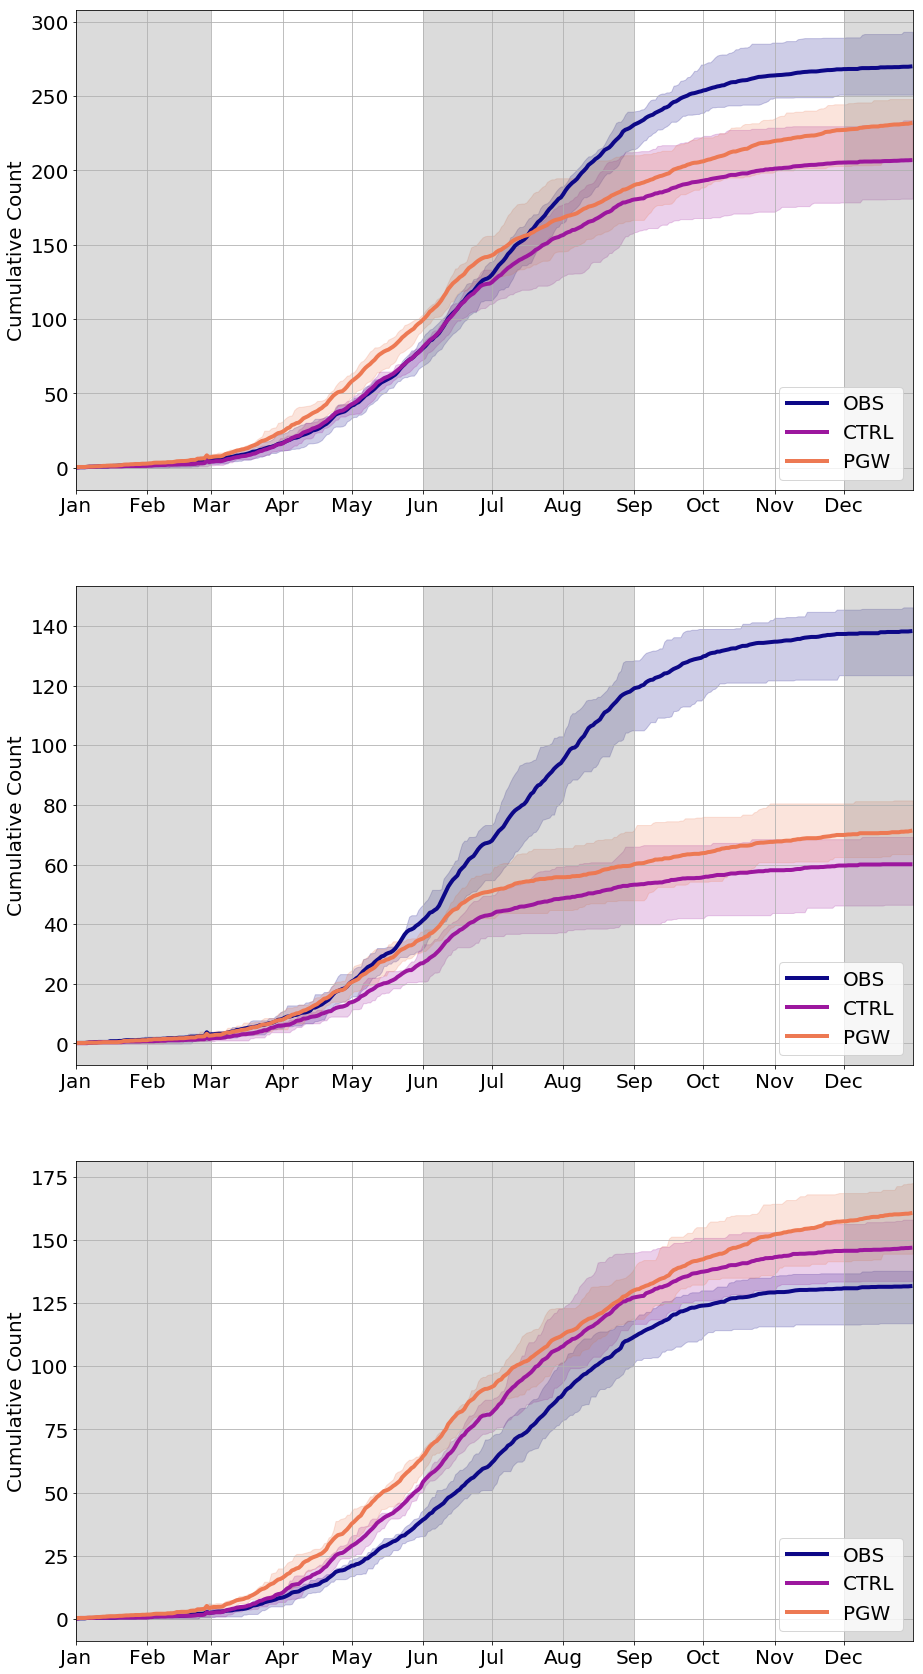

In [9]:
plt.rcParams['figure.figsize'] = 15, 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

month_doy = {'Jan':1, 'Feb':32, 'Mar':60, 
             'Apr':91, 'May':121, 'Jun':152, 
             'Jul':182, 'Aug':213, 'Sep':244, 
             'Oct':274, 'Nov':305, 'Dec':335}

def draw_cumu_labels(ax):
    ax.set_xlim(1, 365)
    
    ax.set_xticks(list(month_doy.values()))
    ax.set_xticklabels(list(month_doy.keys()))
    
    ax.legend(loc=4, prop={'size': 20})
    
    ax.axvspan(month_doy['Jan'], month_doy['Mar'], facecolor='0.5', alpha=0.1)
    ax.axvspan(month_doy['Jun'], month_doy['Sep'], facecolor='0.5', alpha=0.1)
    ax.axvspan(month_doy['Dec'], 365, facecolor='0.5', alpha=0.1)
    ax.grid()
    ax.set_ylabel("Cumulative Count")
    return ax

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    ctrl_ = None
    obs_ = None
    maxyear = 0
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        #Get run and dataset from Midwest subset
        df_ = mw_data[subset][dataset].copy()
        
        #Remove incomplete years
        df_ = df_[(df_.index.year != 2000) & (df_.index.year != 2013)]
        
        #calculate day of year from index
        df_['doy'] = df_.index.dayofyear
        
        #12 years of data with 365 days. Feb 29th added to Feb 28th.
        year_data = np.zeros(shape=(12, 365))
        
        for yid, year in df_.groupby(df_.index.year):
            
            data = []
            
            if yid in [2004, 2008, 2012]:
                
                #iterate 1 to 366 days
                for i in range(1, 367):
                    
                    #business as usual
                    if i != 60:
                        s_count = year[year['doy'].values <= i]
                        data.append(s_count.storm_num.nunique())
                        
                    #Otherwise, add February 29th to February 28th count 
                    else:
                        s_count = year[year['doy'].values <= i]
                        data[-1] += s_count.storm_num.nunique()
            else:
                
                #iterate 1 to 365 days
                for i in range(1, 366):
                    s_count = year[year['doy'].values <= i]
                    data.append(s_count.storm_num.nunique())

            year_data[yid-2001, :] = np.array(data)
                
        p25 = np.percentile(year_data, 25, axis=0)
        p75 = np.percentile(year_data, 75, axis=0)
        mean_ = np.mean(year_data, axis=0)
        
        ax.fill_between(list(range(1, 366)), p25, p75, color=colors[dset_num], alpha=0.2)
        ax.plot(mean_, '-', color=colors[dset_num], linewidth=4, label=dataset)
        
        if dataset == 'OBS':
            obs_ = mean_
        elif dataset == 'CTRL':
            ctrl_ = mean_
            
        ax = draw_cumu_labels(ax)

    print("Jan-Sept OBS - CTRL Diff for:", subset, (obs_[243]-obs_[0]) - (ctrl_[243]-ctrl_[0]))
    print("MAM OBS - CTRL Diff for:", subset, (obs_[151]-obs_[59]) - (ctrl_[151]-ctrl_[59]))
    print("JJA OBS - CTRL Diff for:", subset, (obs_[243]-obs_[151]) - (ctrl_[243]-ctrl_[151]))

#plt.savefig("Figure1.tif", dpi=400, bbox_inches='tight')

# Calculate hourly percentages (JJA)

In [10]:
col_names = ['key'] + [str(x) for x in range(0, 24)]

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])].copy()
        total_count = dset_val.storm_num.nunique()

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr].copy()
            
            hours[str(hr)].append(100*(dset_.storm_num.nunique() / total_count))
            
        hours['key'].append(sub_key + "_" + dset_key)

df = pd.DataFrame.from_dict(hours)
df = df.set_index('key')

for gid, group in df.groupby(df.index):
    
    max_idx = group.idxmax(axis=1).values[0]
    min_idx = group.idxmin(axis=1).values[0]
    
    max_val = group.max(axis=1).values[0]
    min_val = group.min(axis=1).values[0]
    
    print(gid, "\nMax:", max_idx.zfill(2), "z - Max %", max_val, 
               "\nMin:", min_idx.zfill(2), "z - Min %", min_val, '\nMax % Diff', max_val - min_val, '\n')

mcs_CTRL 
Max: 01 z - Max % 51.541850220264315 
Min: 17 z - Min % 18.06167400881057 
Max % Diff 33.480176211453745 

mcs_OBS 
Max: 05 z - Max % 46.60493827160494 
Min: 17 z - Min % 19.290123456790123 
Max % Diff 27.314814814814813 

mcs_PGW 
Max: 02 z - Max % 49.67585089141005 
Min: 17 z - Min % 24.473257698541328 
Max % Diff 25.202593192868722 

non_qlcs_CTRL 
Max: 01 z - Max % 44.642857142857146 
Min: 16 z - Min % 15.376984126984128 
Max % Diff 29.26587301587302 

non_qlcs_OBS 
Max: 05 z - Max % 32.946145723336855 
Min: 17 z - Min % 15.839493136219641 
Max % Diff 17.106652587117214 

non_qlcs_PGW 
Max: 01 z - Max % 42.04671857619577 
Min: 17 z - Min % 20.02224694104561 
Max % Diff 22.024471635150164 

qlcs_CTRL 
Max: 02 z - Max % 73.44632768361582 
Min: 17 z - Min % 24.576271186440678 
Max % Diff 48.87005649717514 

qlcs_OBS 
Max: 06 z - Max % 60.682046138415245 
Min: 18 z - Min % 21.965897693079235 
Max % Diff 38.71614844533601 

qlcs_PGW 
Max: 02 z - Max % 73.13432835820896 
Min: 1

# Calculate hourly min/max differences in counts per year (JJA) 

In [11]:
shrs = [str(x) for x in range(0, 24)]
col_names = ['subset', 'dset'] + shrs

hours = {x:[] for x in col_names}

for sub_key in ['mcs', 'qlcs', 'non_qlcs']:
    for dset_key in ['OBS', 'CTRL', 'PGW']:

        dset_val = mw_data[sub_key][dset_key].copy()
        dset_val = dset_val[dset_val.index.month.isin([6,7,8])].copy()
        total_count = dset_val.storm_num.nunique() 

        for hr in list(range(0, 24)):
            
            dset_ = dset_val[dset_val.index.hour==hr].copy()
            
            hours[str(hr)].append(dset_.storm_num.nunique())
            
        hours['subset'].append(sub_key)
        hours['dset'].append(dset_key)

df = pd.DataFrame.from_dict(hours)

for sset in ['mcs', 'qlcs', 'non_qlcs']:
    
    obs = df[(df.dset=='OBS') & (df.subset==sset)]
    ctrl = df[(df.dset=='CTRL') & (df.subset==sset)]
    
    diff = np.abs(obs[shrs].values - ctrl[shrs].values)
    
    max_idx = np.argmax(diff)
    min_idx = np.argmin(diff)
    
    max_val = np.max(diff) / 13
    min_val = np.min(diff) / 13
    
    print(sset, "\nMax:", max_idx, "z - Max ", max_val, 
               "\nMin:", min_idx, "z - Min ", min_val)

print("\nTotals")
print("\n", df[col_names[:10]])
print("\n", df[col_names[:2] + col_names[10:18]])
print("\n", df[col_names[:2] + col_names[18:]])

mcs 
Max: 10 z - Max  30.846153846153847 
Min: 21 z - Min  3.0
qlcs 
Max: 6 z - Max  29.23076923076923 
Min: 18 z - Min  9.615384615384615
non_qlcs 
Max: 0 z - Max  13.923076923076923 
Min: 16 z - Min  0.3076923076923077

Totals

      subset  dset    0    1    2    3    4    5    6    7
0       mcs   OBS  740  803  853  875  903  906  905  880
1       mcs  CTRL  674  702  700  683  661  622  582  529
2       mcs   PGW  577  611  613  605  591  551  521  476
3      qlcs   OBS  484  534  564  579  592  594  605  580
4      qlcs  CTRL  237  252  260  259  250  244  225  209
5      qlcs   PGW  215  233  245  240  242  233  222  212
6  non_qlcs   OBS  256  269  289  296  311  312  300  300
7  non_qlcs  CTRL  437  450  440  424  411  378  357  320
8  non_qlcs   PGW  362  378  368  365  349  318  299  264

      subset  dset    8    9   10   11   12   13   14   15
0       mcs   OBS  861  835  809  747  681  617  552  469
1       mcs  CTRL  489  448  408  368  349  315  285  256
2       mcs  

# Draw hourly counts of events

C:\Users\ahaberlie\Anaconda3\envs\py36\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


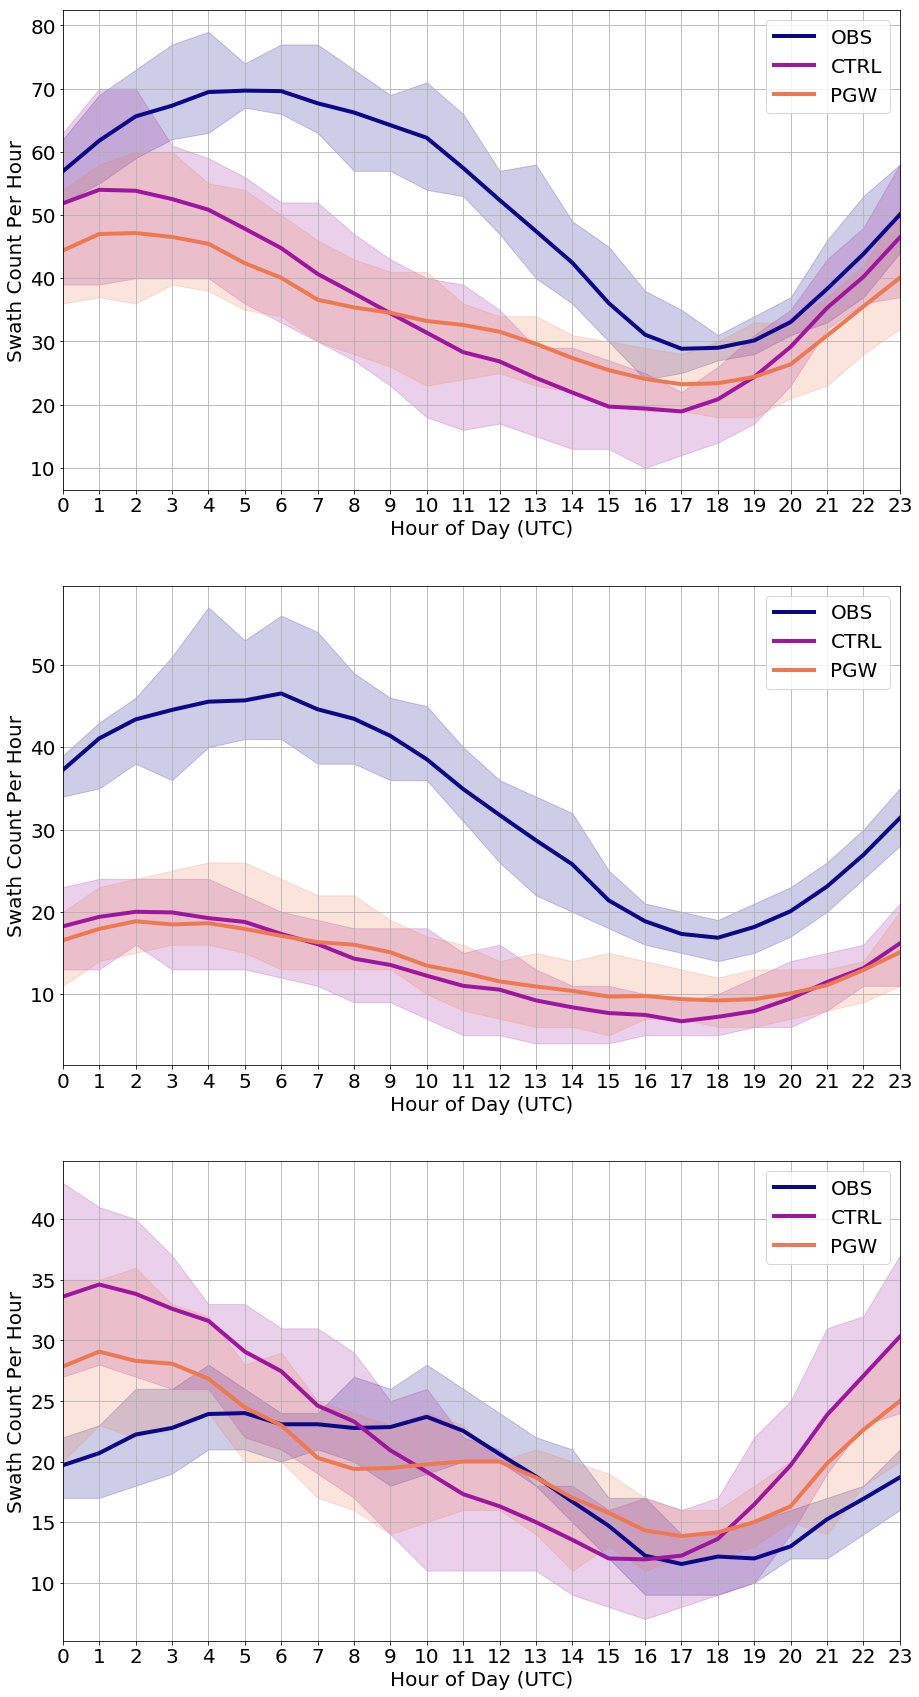

In [12]:
plt.rcParams['figure.figsize'] = 15, 30
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.labelsize'] = 20

def draw_hour_labels(ax, lab):
    ax.set_xlim(0, 23)
    ax.legend(prop={'size': 20})

    ax.set_ylabel("Swath Count Per Hour")
    ax.set_xlabel("Hour of Day (UTC)")
    ax.set_xticks(list(range(0, 24)))
    #ax.set_title(lab + " Swath Count by Hour of Day", fontsize=20)
    ax.grid()

colors = [plt.cm.plasma(x/3) for x in range(0, 3)]

for subplot, subset in enumerate(['mcs', 'qlcs', 'non_qlcs']):
    for dset_num, dataset in enumerate(['OBS', 'CTRL', 'PGW']):
        
        ax = plt.subplot(3, 1, subplot+1)
        
        df_ = mw_data[subset][dataset].copy()
        df_ = df_[df_.index.month.isin([6,7,8])].copy()

        years = df_.groupby(df_.index.year)
        year_data = np.zeros((13, 24), dtype=int)
        
        for yid, year in years:
            hour_data = []
            for hid in range(0, 24):

                hour = year[year.index.hour==hid]
                hour_data.append(len(np.unique(hour.storm_num.values)))
                
            year_data[yid-2001, :] = np.array(hour_data)

        p25 = np.percentile(year_data, 25, axis=0)
        p75 = np.percentile(year_data, 75, axis=0)
        plt.fill_between(list(range(24)), p25, p75, color=colors[dset_num], alpha=0.2)
        plt.plot(np.mean(year_data, axis=0), '-', color=colors[dset_num], linewidth=4, label=dataset)
        
        ax = draw_hour_labels(ax, subset.upper())
        
#plt.savefig("Figure2.tif", dpi=400, bbox_inches='tight')